Per questo notebook, che ha lo scopo di fornire una panoramica su alcuni strumenti legati all'analisi di reti e di fenomeni di diffusione dell'informazione su di esse, utilizzeremo tre grafi differenti:
- Un piccolo dataset famoso nella Network Science: [Zachary's Karate Club](http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm). La costruzione di questo dataset è legato a una storia interessante e rappresenta uno delle prime applicazioni degli algoritmi di Community Detection, lascio quindi ai più curiosi un riferimento per [approfondire](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).  
- Il grafo di [Erdos-Rènyi](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)
- Il grafo delle interazioni dei personaggi di [Game of Thrones](https://github.com/mathbeveridge/asoiaf)

# Introduzione

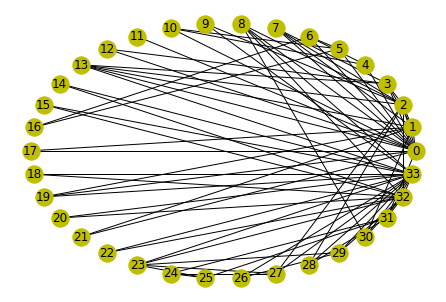

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.karate_club_graph()
nx.draw_circular(G, with_labels=True,node_color='y')
plt.show()

I nodi possono avere informazione (attributi)

In [2]:
G.nodes[0]

{'club': 'Mr. Hi'}

Posso aggiungere attributi, modificarne i valori, ...

In [3]:
G.nodes[0]['status'] = 'infected'

E colorare in base ad essi la rete

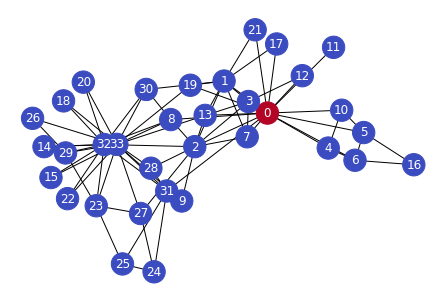

In [4]:
values = [1 if e=='infected' else 0. for e in \
          [G.nodes[i].get('status','susceptible') for i in range(0,len(G.nodes))]]

nx.draw(G, cmap=plt.cm.coolwarm, node_color=values, with_labels=True, font_color='white',node_size=500)
plt.show()

In [5]:
del(G.nodes[0]['status'])

Visualizziamo con una mappa di calore un indice di centralità della rete

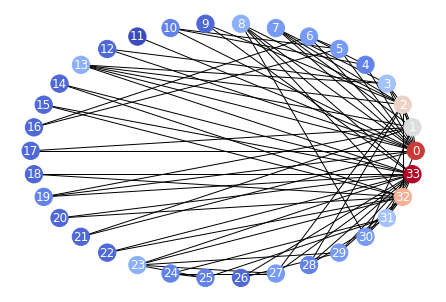

In [6]:
deg_centrality_values = list(nx.degree_centrality(G).values())

nx.draw_circular(G, with_labels=True, node_color=deg_centrality_values, cmap=plt.cm.coolwarm,font_color='white')
plt.show()

Una misura dell'intera rete che rende conto dei legami tra nodi simili sugli attributi è l'[assortatività](http://networksciencebook.com/chapter/7#assortativity).

In [7]:
assortativity = nx.attribute_assortativity_coefficient(G,'club')
print("L'assortatività sul club del Karate Club è {}".format(assortativity))

L'assortatività sul club del Karate Club è 0.717530864197531


# Spatial Spreading

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

#### Cos'è un diagramma di Voronoi?
Nel caso più semplice e comune, quello del piano, dato un insieme finito di punti S, il diagramma di Voronoi per S è la partizione del piano che associa una regione V(p) ad ogni punto p ∈ S in modo tale che tutti i punti all'interno del perimetro di V(p) siano più vicini a p che a ogni altro punto in S. 

In [9]:
def visualize_voronoi_diagram(points,axes):
    vor = Voronoi(points)
    voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1,ax=axes)

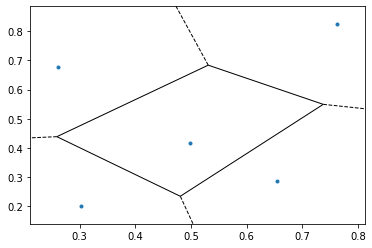

In [10]:
points = np.random.uniform(size=[5, 2])
visualize_voronoi_diagram(points,plt.axes())

#### Visualize Spatial Spreading

- Generiamo uniformemente a caso delle torrette telefoniche in uno spazio a due dimensioni.
- Generiamo estrando da una distribuzione uniforme il numero di cellulari infetti in una cella
- Costruiamo la tesselazione Voronoi
- Normalizziamo i valori degli infetti e stampiamo il diagramma di Voronoi colorandolo con una mappa di calore

In [11]:
def visualize_spatial_spreading(points,values,axes):
    # generate Voronoi tessellation
    vor = Voronoi(points)
    
    # find min/max values for normalization
    minima = min(values)
    maxima = max(values)
    
    # normalize chosen colormap
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)
    
    # plot Voronoi diagram, and fill finite regions with color mapped from values
    voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1,ax=axes)
    for r in range(len(vor.point_region)):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            axes.fill(*zip(*polygon), color=mapper.to_rgba(values[r]))

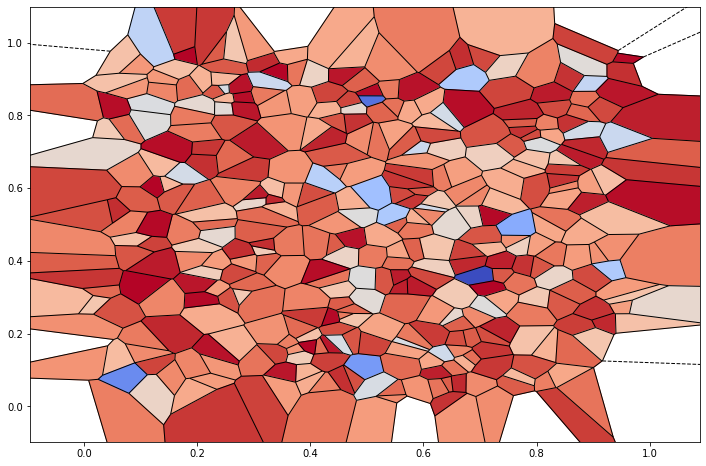

In [12]:
# generate data points (towers) /infected values
numtower = 400
dimension = 2

celltowers = np.random.uniform(size=[numtower, dimension])
infected_in_cell = np.random.power(5.,size=numtower) # P(X=a) ax^(a-1) ; a = .5

# visualize
plt.figure(figsize=(12,8))
ax = plt.axes()
visualize_spatial_spreading(celltowers,infected_in_cell,ax)
plt.show()

In [13]:
def scale(values):
    median = np.median(values)
    iqr = np.quantile(values,0.75) - np.quantile(values,0.25)
    return list(map(lambda x: (x-median)/iqr,values))

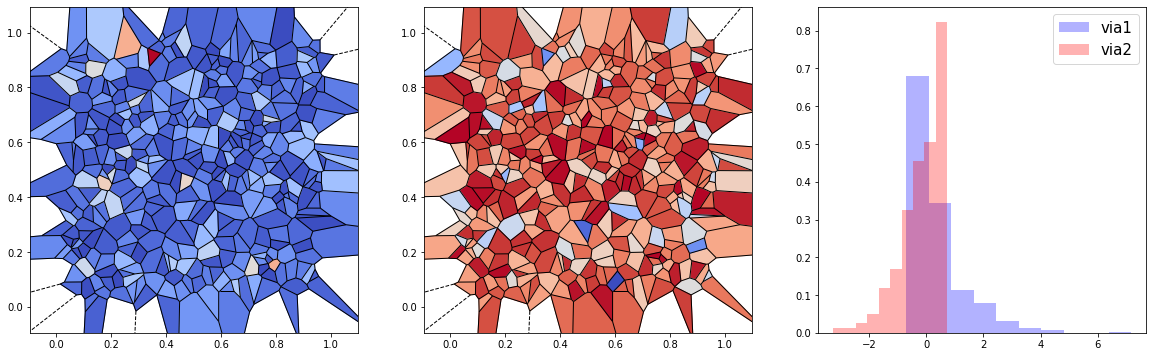

In [14]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(131) #rows, columns, index
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

celltowers = np.random.uniform(size=[numtower, dimension])
infected_in_cell_via1 = np.random.exponential(5.,size=numtower) #5. = \beta = 1 / \lambda
infected_in_cell_via2 = np.random.power(5.,size=numtower) # P(X=a) ax^(a-1) ; a = .5

visualize_spatial_spreading(celltowers,infected_in_cell_via1,ax1)
visualize_spatial_spreading(celltowers,infected_in_cell_via2,ax2)

ax3.hist(scale(infected_in_cell_via1), density=True, alpha=0.3,color='blue',label='via1')
ax3.hist(scale(infected_in_cell_via2), density=True, alpha=0.3,color='red',label='via2')
ax3.legend(prop={'size': 15})

plt.show()

# Epidemics

Per fare una piccola simulazione del diffondersi di un'epidemia utilizzeremo la libreria [NDLib](https://ndlib.readthedocs.io/en/latest/)

In [15]:
#!pip install ndlib

In [16]:
import ndlib
import ndlib.models.epidemics as ep
import json

Costruiamo il grafo

In [17]:
#Number of Nodes, Density := probability there is a link between 2 nodes
contact_network = nx.erdos_renyi_graph(1000, 0.1) 

In [18]:
#Create the epidemic model
model = ep.SISModel(contact_network)

#Display model parameters and statuses
print(json.dumps(model.parameters, indent=2))
print()
print('Statuses: ',model.available_statuses)

{
  "model": {
    "beta": {
      "descr": "Infection rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "lambda": {
      "descr": "Recovery rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "tp_rate": {
      "descr": "Whether if the infection rate depends on the number of infected neighbors",
      "range": [
        0,
        1
      ],
      "optional": true,
      "default": 1
    }
  },
  "nodes": {},
  "edges": {}
}

Statuses:  {'Susceptible': 0, 'Infected': 1}


In [19]:
import ndlib.models.ModelConfig as mc

cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001) # infection rate
cfg.add_model_parameter('lambda', 0.01) # recovery rate
cfg.add_model_parameter("percentage_infected", 0.01)
model.set_initial_status(cfg)

### Simulazione
I modelli di ``NDlib`` diffondo i fenomeni come processi **discrete-time**, **agent-based**: durante ogni iterazione tutti i nodi sono valutati e i loro stati aggiornati in accordo alle regole del modello.

In [20]:
iterations = model.iteration_bunch(200, node_status=True) #display status per node per iteration
iterations[-1] #0: Susceptible, 1: Infected

100%|██████████| 200/200 [00:02<00:00, 79.33it/s] 


{'iteration': 199,
 'status': {8: 0,
  20: 1,
  35: 1,
  39: 0,
  42: 1,
  60: 1,
  106: 1,
  108: 0,
  200: 0,
  296: 0,
  301: 0,
  346: 1,
  350: 1,
  383: 0,
  403: 0,
  421: 1,
  443: 0,
  463: 0,
  467: 0,
  478: 1,
  513: 1,
  528: 1,
  534: 1,
  630: 0,
  659: 1,
  693: 0,
  859: 1},
 'node_count': {0: 99, 1: 901},
 'status_delta': {0: -1, 1: 1}}

Potremmo visualizzare i trend, informazioni slegate dalla singola iterazione...

In [21]:
trends = model.build_trends(iterations)

Ci viene in aiuto ancora una volta la visualizzazione

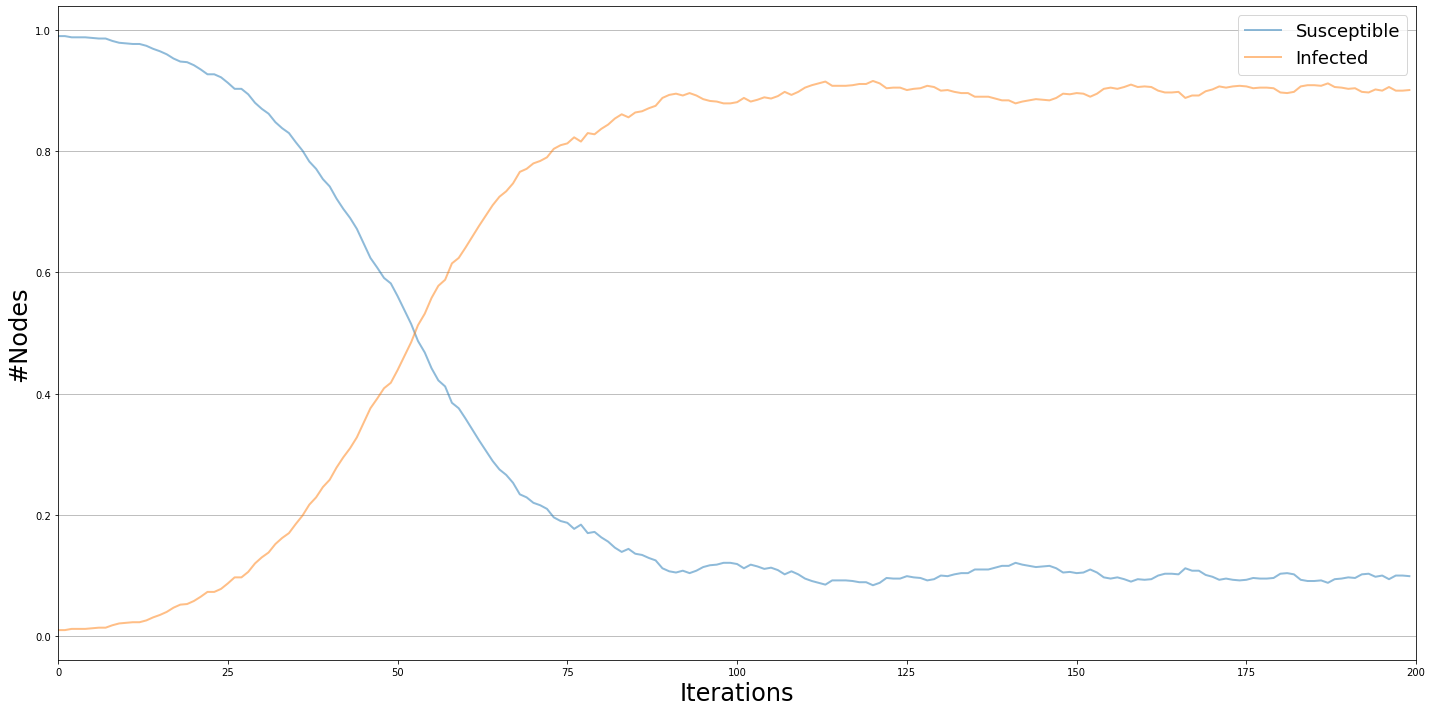

In [22]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
viz = DiffusionTrend(model, trends)
viz.plot()

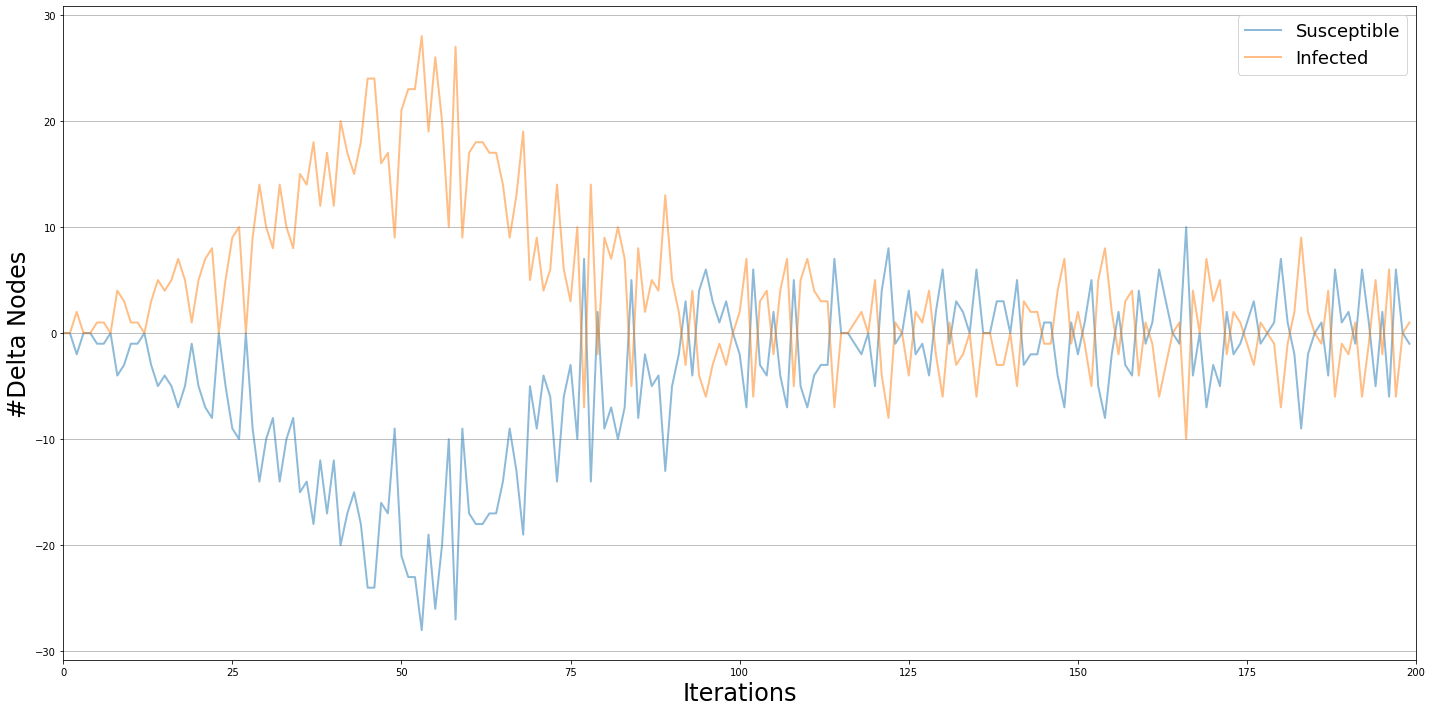

In [23]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
viz = DiffusionPrevalence(model, trends)
viz.plot()

### Perchè predirre l'andamento di un'epidemia non è così semplice?
- Le reti reali non sono statiche.  
- Le reti reali non sono omogenee.  
- Non abbiamo una conoscenza totale dei legami nella rete.  
- Violazione dell'ipotesi di compartimentalizzazione.

#### Violazione dell'ipotesi di omogeneità

Il modello SIS standard si basa sull'assunzione che le reti siano omogenee, cioè che tutti i nodi hanno un numero di link molto simile tra loro e la probabilità che ci sia un link scelti due nodi uniformemente a caso è uguale per ogni coppia di nodi. Tuttavia, recenti lavori di ricerca hanno dimostrato che le reti di contatto sociale sono divise in community in cui i nodi hanno collegamenti diversi e i nodi hanno generalmente più collegamenti con i nodi nella propria community rispetto a quelli con i nodi delle altre. Pertanto, quando in una comunità è presente un numero significativo di individui infetti, i contatti effettuati (i contatti che trasmettono malattie) tra individui suscettibili e infetti non crescono rapidamente. Questo fenomeno è chiamato "crowding" o "protection effect". Pertanto, la forza lineare di infezione utilizzata nel modello SIS standard ha dei limiti nello scenario reale.

Proviamo a visualizzare la distribuzione del grado dei nodi del grafo delle interazioni tra i personaggi di [Game of Thrones](https://github.com/mathbeveridge/asoiaf), comparandola con l'equivalalente distribuzione del grado di una rete casuale.

In [24]:
#!wget https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-all-edges.csv

In [25]:
import pandas as pd
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

df = pd.read_csv('asoiaf-all-edges.csv')
G = nx.from_pandas_edgelist(df,'Source','Target',['weight'])

In [26]:
degree = list(dict(G.degree()).values())
print('Mean degree: {}'.format(np.mean(degree)))
print('Standard deviation: {}'.format(np.std(degree)))
print('Median: {}'.format(np.median(degree)))
print('Min: {}'.format(np.min(degree)))
print('Max: {}'.format(np.max(degree)))

Mean degree: 7.092964824120603
Standard deviation: 12.676647336430479
Median: 3.0
Min: 1
Max: 122


In [27]:
random_graph = nx.fast_gnp_random_graph(G.order(),nx.density(G))
random_degree = list(dict(random_graph.degree()).values())

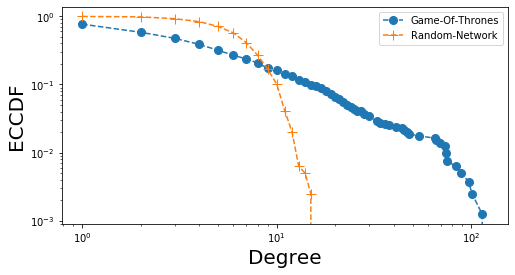

In [28]:
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)

cdf_random = ECDF(random_degree)
x_random = np.unique(random_degree)
y_random = cdf_random(x_random)

fig_cdf = plt.figure(figsize=(8,4))
axes = fig_cdf.gca()
axes.set_xscale('log')
axes.set_yscale('log')
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--',label='Game-Of-Thrones')
axes.loglog(x_random,1-y_random,marker='+',ms=10, linestyle='--',label='Random-Network')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size = 20)
axes.legend()
plt.show()

Come è possibile vedere non tutti i nodi hanno in media lo stesso grado ma esistono dei nodi che hanno un grado molto maggiore rispetto alla maggior parte dei nodi. Tali nodi vengono detti hub e reti di questo tipo sono dette scale free in quanto non è possibile stabilire un ordine di grandezza per la distribuzione del grado dei nodi. Tantissime reti reali, tra cui le social network e le reti di contatto, sono scale-free.